# Goal

* Map variation between B73 and others on the phylogeny

# Setting variables

In [39]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [40]:
%%R

nprocs = 20

workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/'
figDir = '/home/bryan/RhizCG/figures/ms_figures/'

RhizEnrichedFile = file.path(workDir, 'l2f_B73vsGenotype.csv')


# Init

In [41]:
%%R
library(phyloseq)
library(dplyr)
library(tidyr)
library(ggplot2)
library(grid)
library(gridExtra)
library(foreach)
library(doParallel)
library(reshape2)

# Loading files

In [42]:
# %%R 
# #use non-rarified phyloseq object
# F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3')
# #F.r = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3_r')
# physeq.Full = readRDS(F)
# physeq.Full.m = physeq.Full %>% sample_data
# physeq.Full


In [43]:
%%R
# use rarified object for subsetting tree based on abundance
F.r = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3_r')
physeq.Full.r = readRDS(F.r)
physeq.Full.r

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [44]:
%%R 
# subset to rhizosphere samples
physeq.plant = subset_samples(physeq.Full.r, Plant != "BARE")
physeq.plant

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [45]:
%%R 
# log2 fold change analysis results file
df.l2fc = read.delim(RhizEnrichedFile, sep=',')
df.l2fc %>% head(n=3)

   baseMean log2FoldChange    pvalue      padj      OTU    Rank1         Rank2
1 0.7037793      0.9585745 0.2610125        NA OTU.5899 Bacteria Acidobacteria
2 2.6175394     -0.3806323 0.5138391 0.8174481 OTU.8680 Bacteria Acidobacteria
3 1.1962488      1.0134831 0.1760730 0.5140098 OTU.2666 Bacteria Acidobacteria
       Rank3                Rank4                Rank5 Rank6 Rank7 Rank8  Plant
1      32-21 uncultured_bacterium                 <NA>  <NA>  <NA>  <NA> 75-062
2 Holophagae              Sva0725                 <NA>  <NA>  <NA>  <NA> 75-062
3 Holophagae              Sva0725 uncultured_bacterium  <NA>  <NA>  <NA> 75-062


In [46]:
# %%R
# #join 
# p.sd = sample_data(physeq.plant)
# LT = unique(p.sd[,c(9,13)]) 
# head(LT)

In [47]:
# %%R
# #join DAP with l2fc

# df.l2fc = left_join(df.l2fc, LT, by = "Plant")
# head(df.l2fc)


# Filter to abundant taxa

In [48]:
%%R
# filter taxa from the plant subset, while using the abundance in the overall dataset
physeq.thresh <- prune_taxa(names(sort(taxa_sums(physeq.Full.r),TRUE)[1:200]), physeq.plant)

physeq.thresh    


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 200 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 200 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 200 tips and 199 internal nodes ]


In [49]:
%%R
physeq.thresh %>% 
    tax_table() %>%
    as.data.frame %>%
    select(Rank2) %>%
   .$Rank2 %>% levels

 [1] "Acidobacteria"          "Actinobacteria"         "Bacteroidetes"         
 [4] "Candidate_division_WS3" "Chloroflexi"            "Firmicutes"            
 [7] "Gemmatimonadetes"       "Nitrospirae"            "Proteobacteria"        
[10] "Verrucomicrobia"       


In [50]:
%%R
# Define tree color palete
TreeColors = c("#1f78b4", #acidobacteria, 
               "#9a9a00", #Actinobacteria, 
                "#4b0082",  #Bacteroidetes,
               "#cc4392", #Candidate WS3, 
               "#ff0000",  #Chloroflexi, 
               #"#e31a1c", #Cyanobacteria, 
                '#ffff00', #firmicutes
              "#ff8000",  #Gemmatoidetes, 
             #  "#000000",  #"JL-ETNP-Z39", 
               "#000000", #Nitrospirae
             #   "#00ff00", #Planctomycetes,
               "#008000", #proteobacteria 
              "#299a9f")  #Verrucomicrobia


# Functions for making plots

## Making tree plot & metadata plots separately, then combining with grid.arrange

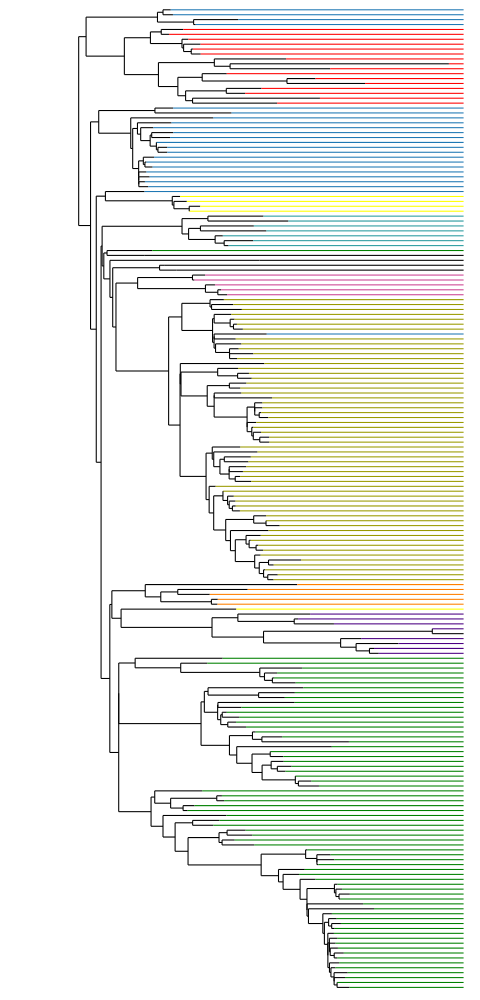

In [51]:
%%R -h 1000

plot_tree = function(physeq, color.rank="Rank2", legend.title='Phylum', 
                     plot.margin=NULL, y.expand=c(0.01,0.01),
                     legend.position='none', legend.size=4){
    # general tree plotting with ggplot
    as.Num = function(x){ x %>% as.character %>% as.numeric }
    
    # plot margin
    if(is.null(plot.margin)){
        plot.margin = unit(c(0,0,0,0), "cm")  # top, right, bottom, left        
    }

    # get tree coords
    treeSegs = phyloseq:::tree_layout(phy_tree(physeq), ladderize='right')

    # edge parsing 
    edge_inner = treeSegs$edgeDT[is.na(treeSegs$edgeDT$OTU)]
    edge_otu = treeSegs$edgeDT[! is.na(treeSegs$edgeDT$OTU)]

    # adding taxonomy to left edges
    physeq.tax = physeq %>% tax_table %>% as.matrix %>% as.data.frame %>%
        mutate(OTU = rownames(.))
    edge_otu.df = edge_otu %>% as.matrix %>% as.data.frame %>%
        mutate(xleft = xleft %>% as.Num,
               xright = xright %>% as.Num,
               y = y %>% as.Num)
    edge_otu.df = inner_join(edge_otu.df, physeq.tax, c('OTU' = 'OTU')) %>%
        mutate(Rank2 = gsub('^__', '', Rank2),
               Rank3 = gsub('^__', '', Rank3),
               Rank4 = gsub('^__', '', Rank4),
               Rank5 = gsub('^__', '', Rank5),
               Rank6 = gsub('^__', '', Rank6),
               Rank7 = gsub('^__', '', Rank7),
               Rank8 = gsub('^__', '', Rank8)) 
    
    # adding node-metadata connector lines
    edge_otu.con = edge_otu.df %>%
                     mutate(max.xright = max(xright, na.rm=T),
                            xleft = xright,
                            xright = max.xright)
    
    # dummy facet
    edge_inner$FACET = 1
    
    # making tree plot
    p.tree = ggplot(data=edge_inner) + 
        geom_segment(aes(x=xleft, xend=xright, y=y, yend=y)) + 
        geom_segment(data=edge_otu.df, 
                     aes(x=xleft, xend=xright, y=y, yend=y)) +
        geom_segment(data=edge_otu.con,
                     aes_string(x="xleft", xend="xright", y="y", 
                                yend="y", color=color.rank)) + 
        geom_segment(data=treeSegs$vertDT, 
                     aes(x=x, xend=x, y=vmin, yend=vmax)) +
        scale_y_continuous(expand=y.expand) +
        scale_color_manual(values = TreeColors, legend.title) +
        #facet_grid(. ~ FACET) +
        theme_bw() +
        guides(colour = guide_legend(override.aes = list(size=legend.size))) +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),
            panel.background = element_blank(),
            axis.title = element_blank(),
            axis.text = element_blank(),
            axis.ticks = element_blank(),
            legend.position = legend.position,
            legend.background = element_blank(),
            legend.key = element_blank(),
            legend.text = element_text(size = 11),
            strip.background = element_blank(),
            strip.text = element_blank(),
            plot.margin = plot.margin
            )
    return(p.tree)
    }

#-- test --#
p.tree = plot_tree(physeq.thresh, 
          legend.title='Phylum', 
          legend.position='none', 
          plot.margin=unit(c(0,-0.1,0,2),'cm'))
p.tree

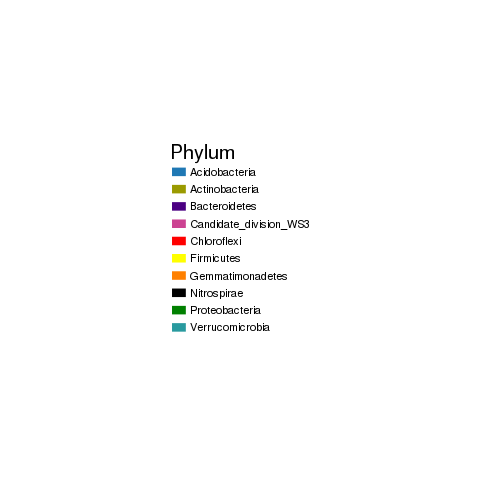

In [52]:
%%R

g_legend = function(a.gplot, text.size = 20, legend.position=c(0.5, 0.5)){ 
    # function for plotting just legend
    a.gplot = a.gplot + theme(legend.position=legend.position, 
                              text = element_text(size=text.size))
    tmp = ggplot_gtable(ggplot_build(a.gplot)) 
    leg = which(sapply(tmp$grobs, function(x) x$name) == "guide-box") 
    legend = tmp$grobs[[leg]] 
    return(legend)
    } 
                        
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [53]:
%%R
# saving legend
outFile = '200Tree_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=3, height=5)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


In [54]:
%%R
#Save legend for 

NULL


## Order metadata to tree

In [55]:
%%R 

as.Num = function(x){ x %>% as.character %>% as.numeric }

order_metadata_to_tree = function(physeq, metadata){
    # function for parsing & giving y (y.tree) value to metadata
        
    # get tree coords
    treeSegs = phyloseq:::tree_layout(phy_tree(physeq), ladderize='right')

    # edge parsing 
    edge_otu.df = treeSegs$edgeDT[! is.na(treeSegs$edgeDT$OTU)] %>%
                as.matrix %>% 
                as.data.frame %>%
                mutate(y.tree = y %>% as.Num) %>%
                select(OTU, y.tree)
    
    # joining leaf edge and metadata
    inner_join(edge_otu.df, metadata, c('OTU' = 'OTU'))     
    }

#-- test --#
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)

df.l2fc.ord = order_metadata_to_tree(physeq.thresh, df.l2fc.s) 
df.l2fc.ord %>% head(n=4)

      OTU y.tree baseMean log2FoldChange     pvalue       padj  Plant
1 OTU.212    195 34.87824   -0.005084731 0.98449583 0.99494047 75-062
2 OTU.212    195 23.00824   -0.300473249 0.31609326 0.61532821  ABUTH
3 OTU.212    195 36.17518   -0.689588209 0.01636206 0.07564228  AMAPO
4 OTU.212    195 45.12994    0.454210016 0.14179777 0.38643788    B97


In [56]:
%%R
sample_data(physeq.thresh)$Type %>% levels

[1] "C4_Grass"  "Dicot-Myc" "Dicot-NM"  "Legume"    "Maize"    


## Order plants by Day

In [57]:
%%R
# Goal order to Type
# input for function is the log2fold change table and the trimmed phyloseq object the tree is based on


order_plants_by_type = function(metadata, physeq, ...){
    
## remove bare soil controls
## Arange by Day and Plant, gather levels and use to order metadata
 physeq.p = subset_samples(physeq, Plant != "BARE") 
     sample_data(physeq.p)$Type = factor(sample_data(physeq.p)$Type, 
                                                 levels = c("Maize", "C4_Grass", 
                                                            "Dicot-Myc","Dicot-NM","Legume"))
        physeq.p.sd = physeq.p %>%        
            sample_data() %>%
            arrange(Type)

        PlantOrder = unique(physeq.p.sd$Plant)
        
        
    metadata$Plant = factor(metadata$Plant, levels=PlantOrder)
    return(metadata)
       

       
}

df.l2fc.ord2 = order_plants_by_type(df.l2fc.ord, physeq.thresh, cores=nprocs)
df.l2fc.ord2 %>% head(n=4)

      OTU y.tree baseMean log2FoldChange     pvalue       padj  Plant
1 OTU.212    195 34.87824   -0.005084731 0.98449583 0.99494047 75-062
2 OTU.212    195 23.00824   -0.300473249 0.31609326 0.61532821  ABUTH
3 OTU.212    195 36.17518   -0.689588209 0.01636206 0.07564228  AMAPO
4 OTU.212    195 45.12994    0.454210016 0.14179777 0.38643788    B97


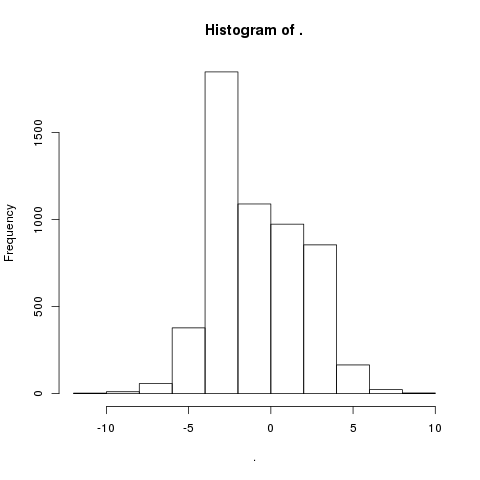

In [58]:
%%R
df.l2fc %>% 
    filter (padj < 0.05) %>%
    .$log2FoldChange %>%
    hist()

## Function for log2fold change plot

In [59]:
%%R
head(df.l2fc.ord2)

      OTU y.tree baseMean log2FoldChange     pvalue       padj  Plant
1 OTU.212    195 34.87824   -0.005084731 0.98449583 0.99494047 75-062
2 OTU.212    195 23.00824   -0.300473249 0.31609326 0.61532821  ABUTH
3 OTU.212    195 36.17518   -0.689588209 0.01636206 0.07564228  AMAPO
4 OTU.212    195 45.12994    0.454210016 0.14179777 0.38643788    B97
5 OTU.212    195 22.58088    0.180536813 0.64873855 0.85657913  ECHCG
6 OTU.212    195 17.08514   -0.274338322 0.39905084 0.69773390  ELCOR


In [60]:
%%R
theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }

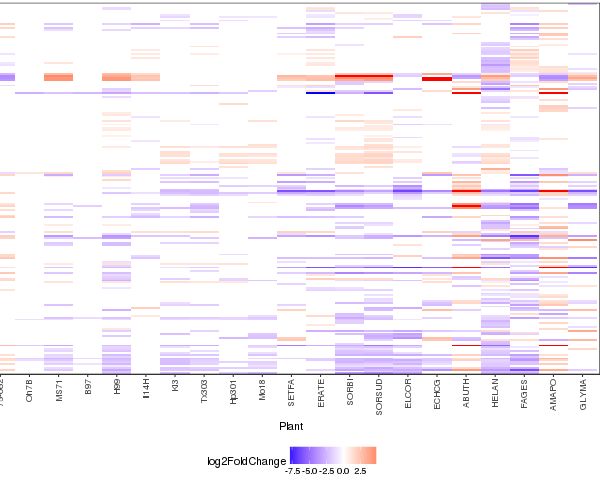

In [74]:
%%R -w 600

# function for making incorporator plot
responders_plot = function(metadata, plot.margin=NULL){
    if(is.null(plot.margin)){
        plot.margin = unit(c(0.1,0,0,-0.7), "cm")  # top, right, bottom, left        
    }
   
  
    
    metadata.ord = metadata %>%
        mutate(responder = padj < 0.05,
               responder.num = responder %>% as.numeric) #,
               #Day = DAP %>% as.character)
    
    #metadata.ord$Day = reorder(metadata.ord$Day, metadata.ord$Day %>% as.numeric)

    min.y = metadata.ord$y.tree %>% min(na.rm=T)
    max.y = metadata.ord$y.tree %>% max(na.rm=T)    
    
    # add dummy variable to allow faceting
   # metadata.ord$FacetLabel = rep("Log[2] Fold Change", nrow(metadata.ord)) %>% as.factor()
    
    Responders_range = filter(metadata.ord, padj <0.05 & log2FoldChange < 5 & log2FoldChange > -8)
    Responders_high = filter(metadata.ord, padj <0.05 & log2FoldChange >= 5)
    Responders_low = filter(metadata.ord, padj <0.05 & log2FoldChange <= -8)
     NonResp = filter(metadata.ord, padj >0.05 )
     Filtered = filter(metadata.ord, is.na(padj))

    p.responder = ggplot() + 
     geom_tile(data = NonResp, aes(x = Plant,y = y.tree), fill = "white") +
        scale_y_continuous(expand=c(0,0)) +

        geom_tile(data = Responders_range, aes(x = Plant,y = y.tree, fill = log2FoldChange)) +
         scale_fill_gradient2( low = "blue", high = "red") +
        scale_y_continuous(expand=c(0,0)) +
    
        geom_tile(data = Responders_high, aes(x = Plant,y = y.tree), fill = "red") +
         #scale_fill_manual( low = "blue", high = "red", mid = "white", limit = c(-6, 4), midpoint = 0) +
        scale_y_continuous(expand=c(0,0)) +
    
        
       # geom_tile(data = Responders_low, aes(x = Plant,y = y.tree), fill = "blue") +
         #scale_fill_manual( low = "blue", high = "red", mid = "white", limit = c(-6, 4), midpoint = 0) +
       # scale_y_continuous(expand=c(0,0)) +
        
    
    
#     p.responder = ggplot(metadata.ord, aes(Day, y.tree, fill=responder, alpha=responder.num)) +
#         geom_tile() +
#         scale_fill_manual(values=c('blue', 'red')) +
#         scale_y_continuous(expand=c(0,0)) +
#        facet_grid(. ~ Plant, scales='free_x') +
        theme_pub() +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.text.x = element_text(angle=90, vjust=0.5, hjust=1),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            legend.position = 'bottom',
            plot.margin = plot.margin    
            )   
    return(p.responder)
    }

#-- test --#
p.responders = responders_plot(df.l2fc.ord2)
p.responders

### Making OTU  abundance plots

In [62]:
# %%R

# # physeq = physeq ob bulk soil samples
# temp = physeq.plant %>% transform_sample_counts(function(x) x / sum(x) ) %>%
#         subset_samples(Plant == "B73") %>%
#         psmelt %>%
#         group_by(Plant, OTU) %>%
#         summarise(meanAbund = mean(Abundance))

#     l2fc.ord.d = df.l2fc.ord2 %>%
#         select(OTU, y.tree) %>%
#         distinct()
    
#     df.B73.j = left_join(l2fc.ord.d,  temp, c('OTU' = 'OTU'))
    
# head(temp) %>% print
# head(df.B73.j) %>% print
# temp = NULL

In [63]:
%%R

B73_abund_plot_df = function(physeq, l2fc.ord){
    # function for creating a df for making reference abundance plot 
    # physeq = physeq ob bulk soil samples
    # physeq = physeq ob bulk soil samples
    
    t = physeq.plant %>% transform_sample_counts(function(x) x / sum(x) ) %>%
        subset_samples(Plant == "B73") %>%
        psmelt %>%
        group_by(Plant, OTU) %>%
        summarise(meanAbund = mean(Abundance))

    l2fc.ord.d = l2fc.ord %>%
        select(OTU, y.tree) %>%
        distinct()
    
    df.B73.j = left_join(l2fc.ord.d,  t, c('OTU' = 'OTU'))
    

    return(df.B73.j)
    }

df.B73 = B73_abund_plot_df(physeq.plant, df.l2fc.ord2) 
df.B73 %>% head(n=3)

#temp = df.bulk %>% group_by(OTU) %>% summarize(sumcount = sum(count_byOTU_norm))
#temp$sumcount %>% summa

        OTU y.tree Plant    meanAbund
1   OTU.212    195   B73 0.0007265985
2    OTU.93    196   B73 0.0012778112
3 OTU.10352    191   B73 0.0008268190


In [64]:
%%R
df.B73$OTU %>% unique %>% length

[1] 200


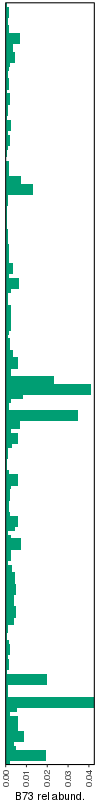

In [65]:
%%R -w 100 -h 800

B73_rel_total_abund_plot = function(df, 
                                     plot.margin=NULL, bar.width=3, 
                                     #total.counts=NULL, 
                                     round.digits=0,
                                     scale.y.log10=FALSE){
    # function for plotting abundances of taxa relative to whole community
    if(is.null(plot.margin)){
        plot.margin = unit(c(.1,.2,0,.2), "cm")  # top, right, bottom, left        
    }

    
#     # summing counts
#     df.s = df %>%
#            group_by(OTU, y.tree) %>%  
#            summarize(min_count_byComm_norm = min(count_byComm_norm),
#                 mean_count_byComm_norm = mean(count_byComm_norm),
#                 max_count_byComm_norm = max(count_byComm_norm)) %>% 
#            ungroup()

#     df.s$B73 = 'B73'
    
 # digit formating
    print.f = paste(c('%.', round.digits, 'f'), collapse='')
    
    # plotting
    p.abund = ggplot(df, aes(y.tree)) +
        geom_bar(aes(y=meanAbund), stat='identity', width=bar.width, fill='#009E73') + 
        scale_y_continuous(expand=c(0,0)) +
        scale_x_discrete(expand=c(0,0))+
        #facet_grid(. ~ Plant) +    
        coord_flip() +
        
        theme_pub() +
        labs(y='B73 rel abund.') +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title.x = element_text(),
            axis.text.x = element_text(angle=90, vjust=0.5, hjust=1),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            #panel.border = element_blank(),
            legend.position = 'none',
            plot.margin = plot.margin    
            ) 
#     if(scale.y.log10){
#         p.abund = p.abund + 
#             scale_y_log10(expand=c(0,0)) 
#     } else {
#         p.abund = p.abund +
#             scale_y_continuous(expand=c(0,0), label=function(x) sprintf(print.f, round(x, round.digits))) 
#     }
    return(p.abund)
    }

#-- test --#
# bulk abundance plots
df.B73 = B73_abund_plot_df(physeq.plant, df.l2fc.ord) 

                           
# total_counts = df.B73 %>% 
#     group_by(Day) %>%
#     summarize(total_count = sum(count)) %>%
#     as.data.frame      
                           
p.rel.total.abund = B73_rel_total_abund_plot(df.B73, 
                                              round.digits=1) 
p.rel.total.abund

In [66]:
%%R -w 800 -h 1000
    
resize_ggplots = function(ggplot.list,
                          resize.index = length(ggplot.list),
                          widths=rep(1, length(ggplot.list))){
    # other.plots = list of plots
    stopifnot(class(ggplot.list)[1] == 'list')
    
    ## making gtables
    make_gt = function(x) ggplot_gtable(ggplot_build(x))
    gt = lapply(ggplot.list, make_gt)
        
    # resizing
    gt.len = length(gt)    
    for(i in 1:gt.len){
        if(i == resize.index){
            next
        } else {
            gt[[i]]$heights = gt[[resize.index]]$heights
        }
    }
        
#     # grid.arrange params
    params.l = list('ncol' = gt.len, 'widths' = widths)

#     # return list of gtables + params
        return(c(gt, params.l))
       
    } 

x = resize_ggplots(list(p.tree, p.responders, p.rel.total.abund))
  #  , widths=c(.6,1.8,0.15)              )
do.call(grid.arrange, x)

# outFile = '/home/bryan/RhizCG/figures/B73xGenotypeHeatmap.jpeg'
# jpeg(outFile, width=9, height=9, units = "in", res = 150)
# do.call(grid.arrange, x)
# dev.off()


Error in grid.Call.graphics(L_setviewport, vp, TRUE) : 
  invalid 'layout.pos.row'


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 4: position_stack requires non-overlapping x intervals 

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 5: position_stack requires non-overlapping x intervals 

  warnings.warn(x, RRuntimeWarning)


# Full Tree

In [75]:
%%R -w 800 -h 1000
# tree plot
p.tree = plot_tree(physeq.thresh, 
                   legend.title=' Phylum', 
                   y.expand=c(0.001,0.001),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.Full, df.l2fc.s) 
## plants by date
df.l2fc.ord = order_plants_by_Library(df.l2fc.ord, physeq.Full, cores=nprocs)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord)

# bulk abundance plots
df.B73 = B73_abund_plot_df(physeq.plant, df.l2fc.ord) 
p.rel.abund = B73_rel_total_abund_plot(df.B73, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
p.rel.total.abund = B73_rel_total_abund_plot(df.B73, bar.width=2, 
                                              plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
# gt = resize_ggplots(list(p.tree, p.responders, p.rel.total.abund),
#                     widths=c(.6,1.8,0.15))

grid.arrange(p.tree, p.responders, p.rel.total.abund, ncol = 3)
#do.call(grid.arrange, gt)


Error in phy_tree(physeq) : object 'physeq.Full' not found


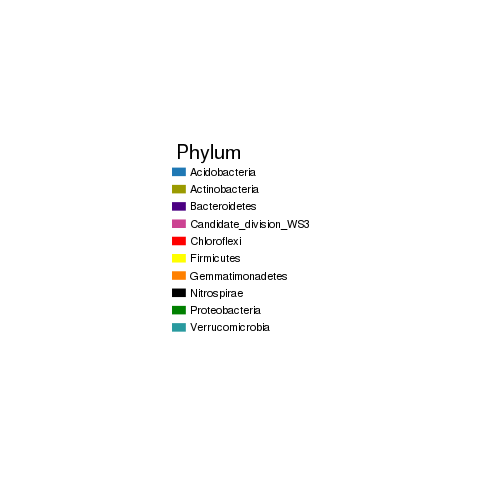

In [68]:
%%R
# tree legend
my.legend = g_legend(p.tree)
grid.draw(my.legend)

# Full tree just abundant

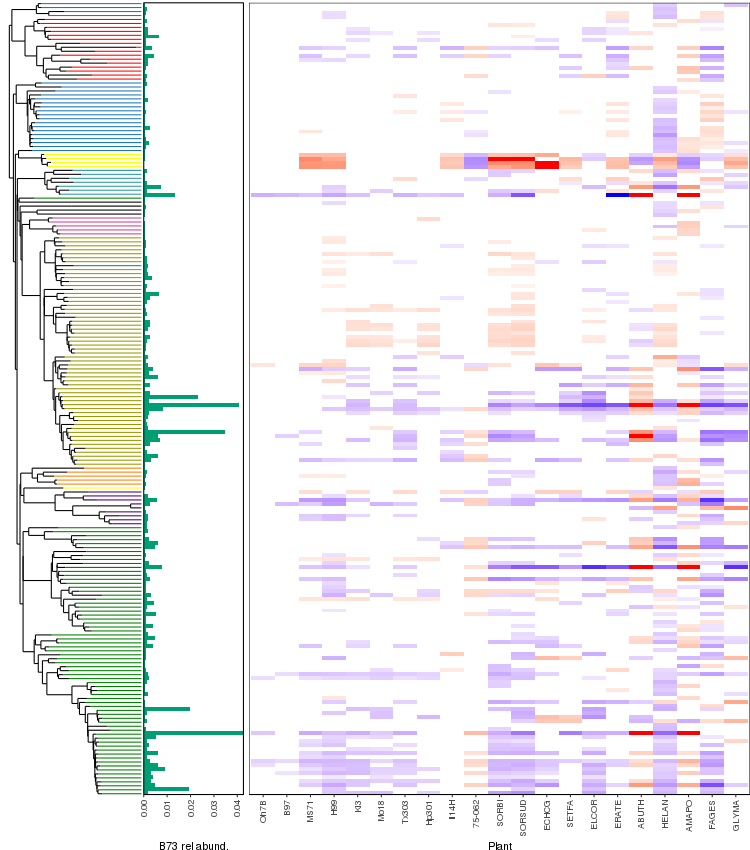

In [76]:
%%R -w 750 -h 850
# tree plot
p.tree = plot_tree(physeq.thresh, 
                   legend.title=' Phylum', 
                   y.expand=c(0.001,0.001),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.thresh, df.l2fc.s) 

##plants to phylogeny, manual
df.l2fc.ord$Plant = factor(df.l2fc.ord$Plant, levels = c("B73", "Oh7B", "B97", "MS71", "H99", "Ki3", "Mo18",
                                                         "Tx303", "Hp301", "Il14H", "75-062", "SORBI", "SORSUD", "ECHCG", "SETFA",  
                                                                      "ELCOR", "ERATE",
                                                                      "ABUTH", "HELAN", "AMAPO","FAGES","GLYMA")) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord)

    g_legend<-function(a.gplot){
        tmp <- ggplot_gtable(ggplot_build(a.gplot))
        leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
        legend <- tmp$grobs[[leg]]
        legend
    }

    legend1 <- g_legend(p.responders)
                            

                     
p.responders =  p.responders + theme(legend.position = 'none')



# bulk abundance plots
df.B73 = B73_abund_plot_df(physeq.plant, df.l2fc.ord) 
p.rel.abund = B73_rel_total_abund_plot(df.B73, plot.margin=unit(c(.2,.2,0,1), 'cm'))
p.rel.total.abund = B73_rel_total_abund_plot(df.B73, bar.width=1, 
                                              plot.margin=unit(c(2,.8,2,-.05), 'cm'))

gt = resize_ggplots(list(p.tree, p.rel.total.abund, p.responders),  widths=c(.6,.5,2))

#layout = rbind(c(1,1,1), c(NA, 2, NA))
#grid.arrange(gt) #legend1, layout_matrix = layout)
p = do.call(grid.arrange, gt)


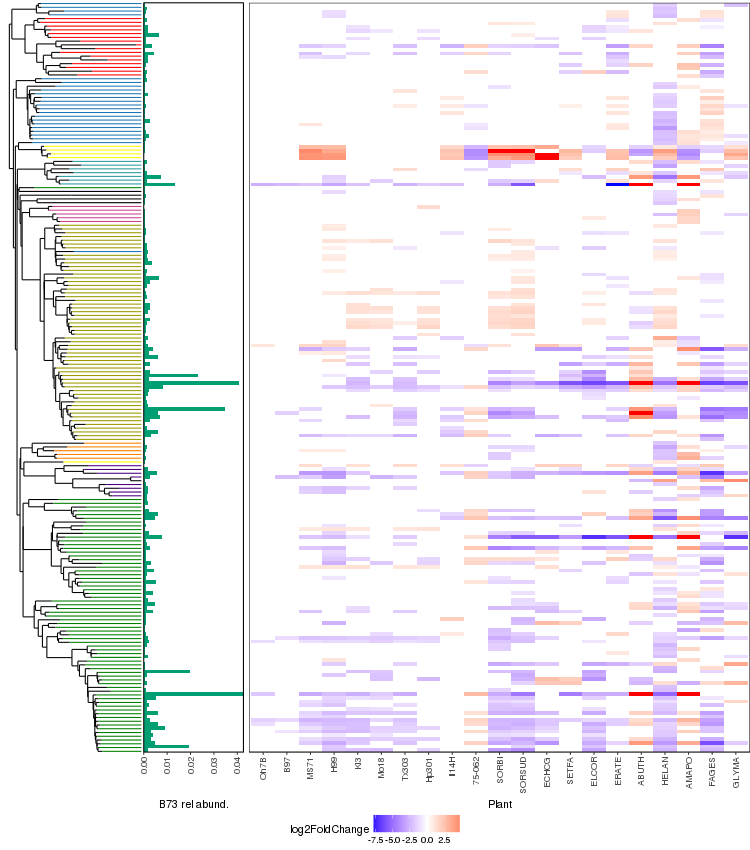

In [77]:
%%R -w 750 -h 850
grid.arrange(p, legend1, ncol = 1, heights = c(1.9, .1))

In [78]:
%%R
# saving figure
outFile = 'l2f_B73xGenotype_Abundant.svg'
outFile = paste(c(figDir, outFile), collapse='/')
svg(outFile, width= 6.00, height= 5)
grid.arrange(p, legend1, ncol = 1, heights = c(1.9, .1))
dev.off()

png 
  2 


* Figure for supplemental: Number of differentially abundant OTUs and average log2 fold change of those OTUs that are differentially abundant

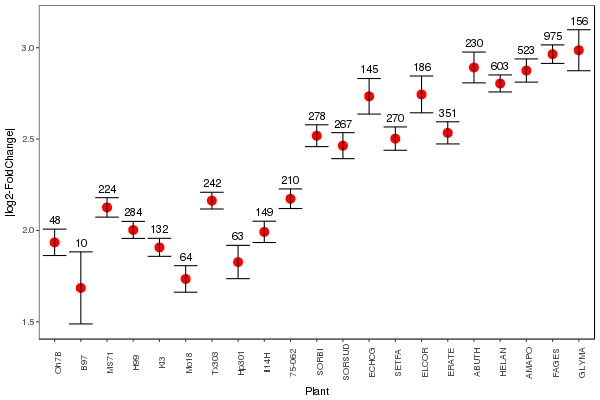

In [71]:
%%R -w 600 -h 400
M.df = df.l2fc %>% 
    filter(padj < 0.05) %>%
    mutate(abs_l2f = abs(log2FoldChange)) %>%
    group_by(Plant) %>% 
    summarize(CountSig = length(padj),
              MedDif = median(abs_l2f),
              MeanDif = mean(abs_l2f),
                SdDif = sd(abs_l2f),
                 SeDif = SdDif/sqrt(CountSig))
#head(sig.df)
M.df$Plant = factor(M.df$Plant, levels = c("B73", "Oh7B", "B97", "MS71", "H99", "Ki3", "Mo18",
                                                         "Tx303", "Hp301", "Il14H", "75-062", "SORBI", "SORSUD", "ECHCG", "SETFA",  
                                                                      "ELCOR", "ERATE",
                                                                      "ABUTH", "HELAN", "AMAPO","FAGES","GLYMA")) 

# function for number of observations 
give.n <- function(x){
  return(c(y = median(x)*1.10, label = length(x))) 
  # experiment with the multiplier to find the perfect position
}

# # function for mean labels
# mean.n <- function(x){
#   return(c(y = median(x)*0.97, label = round(mean(x),2))) 
#   # experiment with the multiplier to find the perfect position
# }

# plot

  
 #stat_summary(fun.data = mean.n, geom = "text", fun.y = mean, colour = "red")
P = ggplot(M.df, aes(x = Plant, y = MeanDif, label = CountSig)) + 
    geom_point(color = "red", size = 4) + 
       geom_errorbar(aes(ymin = (MeanDif - SeDif), ymax = (MeanDif + SeDif))) +
     theme_pub() +
        ylab("|log2-FoldChange|") +
    #ggtitle("Number and mean magnitude of \n differentially abundant OTUs compared to B73")+
     geom_text(aes(y = MeanDif + SeDif + .05)) +
     theme(axis.text.x = element_text(angle = 90))
P

# Quantify # of OTUs differentially abundant

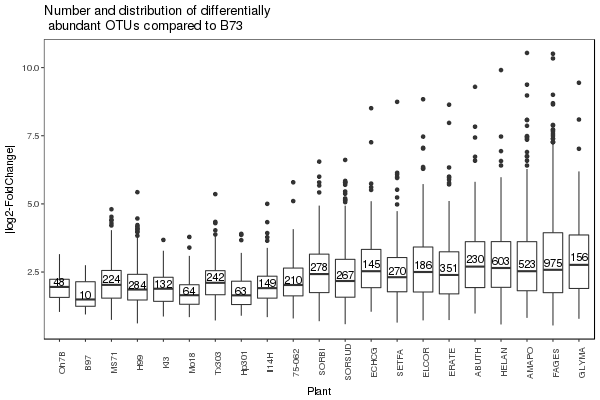

In [34]:
%%R -w 600 -h 400
sig.df = df.l2fc %>% 
    filter(padj < 0.05) %>%
    mutate(abs_l2f = abs(log2FoldChange))
#head(sig.df)
sig.df$Plant = factor(sig.df$Plant, levels = c("B73", "Oh7B", "B97", "MS71", "H99", "Ki3", "Mo18",
                                                         "Tx303", "Hp301", "Il14H", "75-062", "SORBI", "SORSUD", "ECHCG", "SETFA",  
                                                                      "ELCOR", "ERATE",
                                                                      "ABUTH", "HELAN", "AMAPO","FAGES","GLYMA")) 

# function for number of observations 
give.n <- function(x){
  return(c(y = median(x)*1.10, label = length(x))) 
  # experiment with the multiplier to find the perfect position
}

# # function for mean labels
# mean.n <- function(x){
#   return(c(y = median(x)*0.97, label = round(mean(x),2))) 
#   # experiment with the multiplier to find the perfect position
# }

# plot

  
 #stat_summary(fun.data = mean.n, geom = "text", fun.y = mean, colour = "red")
ggplot(sig.df, aes(x = Plant, y =abs_l2f)) +
    theme_pub() +
    geom_boxplot() + 
    ylab("|log2-FoldChange|")+
    stat_summary(fun.data = give.n, geom = "text", fun.y = median) +
    theme(axis.text.x = element_text(angle = 90)) +
    ggtitle("Number and distribution of differentially \n abundant OTUs compared to B73")
#    boxplot(sig.df, x = abs(log2FoldChange), y = Plant)
#     group_by(Plant) %>%
#     summarize(CountSig = length(padj),
#              MedDif = abs(median(log2FoldChange)),
#              MeanDif = abs(mean(log2FoldChange)))

In [35]:
%%R
head(M.df)


Error in head(M.df) : object 'M.df' not found


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Error in head(M.df) : object 'M.df' not found

  warnings.warn(x, RRuntimeWarning)


In [40]:
%%R
outFile = 'l2f_B73xGenotype_meandif.svg'
outFile = paste(c(figDir, outFile), collapse='/')
svg(outFile, width= 7.08, height= 3.5)
P %>% print
dev.off()

png 
  2 


In [42]:
%%R
M.df %>% print(n = 21)

# A tibble: 21 × 6
    Plant CountSig   MedDif  MeanDif     SdDif      SeDif
   <fctr>    <int>    <dbl>    <dbl>     <dbl>      <dbl>
1  75-062      210 2.024826 2.173532 0.7753672 0.05350542
2   ABUTH      230 2.700552 2.891869 1.2780332 0.08427101
3   AMAPO      523 2.530781 2.875029 1.4542044 0.06358792
4     B97       10 1.493599 1.685643 0.6234375 0.19714826
5   ECHCG      145 2.530664 2.733959 1.1703165 0.09718950
6   ELCOR      186 2.500296 2.744456 1.3721914 0.10061396
7   ERATE      351 2.392387 2.533983 1.1368312 0.06067956
8   FAGES      975 2.582372 2.964668 1.5819017 0.05066140
9   GLYMA      156 2.762031 2.986186 1.3997498 0.11206967
10    H99      284 1.857955 2.002841 0.7832485 0.04647724
11  HELAN      603 2.649005 2.804412 1.1416020 0.04648963
12  Hp301       63 1.645291 1.827146 0.7237157 0.09117960
13  Il14H      149 1.909755 1.992134 0.7115495 0.05829240
14    Ki3      132 1.886120 1.907426 0.5656201 0.04923091
15   Mo18       64 1.650870 1.734657 0.5805089 0.0725